In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка для визуализации
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Настройка для корректного отображения русского текста
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## 1.2 Загрузка данных


In [2]:
# Загрузка всех CSV файлов
blackouts_df = pd.read_csv('blackouts.csv')
buildings_df = pd.read_csv('buildings.csv')
districts_df = pd.read_csv('districkts.csv')
folk_districts_df = pd.read_csv('folk_districts.csv')
streets_df = pd.read_csv('streets.csv')
blackouts_buildings_df = pd.read_csv('blackuts_buildings.csv')

print("Данные успешно загружены!")
print(f"\nРазмеры таблиц:")
print(f"- blackouts: {blackouts_df.shape}")
print(f"- buildings: {buildings_df.shape}")
print(f"- districts: {districts_df.shape}")
print(f"- folk_districts: {folk_districts_df.shape}")
print(f"- streets: {streets_df.shape}")
print(f"- blackouts_buildings: {blackouts_buildings_df.shape}")


Данные успешно загружены!

Размеры таблиц:
- blackouts: (25264, 7)
- buildings: (58199, 10)
- districts: (5, 2)
- folk_districts: (3594, 2)
- streets: (2023, 3)
- blackouts_buildings: (1419556, 2)


## 1.3 Исследование структуры данных


In [3]:
# Первый взгляд на данные о перебоях
print("=" * 80)
print("ОСНОВНАЯ ТАБЛИЦА: blackouts")
print("=" * 80)
print(blackouts_df.head())
print("\nКолонки:", blackouts_df.columns.tolist())
print("\nИнформация о данных:")
blackouts_df.info()


ОСНОВНАЯ ТАБЛИЦА: blackouts
                                 id           start_date             end_date  \
0  f88cefa506f44ebf8f010b8681b5449e  2018-01-01 00:08:00  2018-01-01 09:00:00   
1  38ddf6852801fa90cc70f9770239961e  2018-01-01 00:24:00  2018-01-01 10:00:00   
2  53c570099fe380dce9e56e2ace9cfa9c  2018-01-01 10:44:00  2018-01-02 18:00:00   
3  9c1b9ebbd9a698eef046b27cb3568745  2018-01-01 11:32:00  2018-01-01 15:00:00   
4  8aa631cb343aac0731bbde806dfa6d8c  2018-01-01 11:33:00  2018-01-01 15:00:00   

                                         description         type  \
0  Авария на сети электроснабжения, ведутся восст...  electricity   
1  Авария на электролинии, остановка работы насос...   cold_water   
2  Авария в системе водоснабжения дома. Жителям н...    hot_water   
3  Авария на сети электроснабжения, ведутся восст...  electricity   
4  Авария на электролинии, остановка работы насос...    hot_water   

                                      initiator_name  \
0   МУПВ ВПЭС 

In [4]:
# Проверка на пропущенные значения
print("=" * 80)
print("ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
print("=" * 80)
print(blackouts_df.isnull().sum())
print(f"\nВсего строк: {len(blackouts_df)}")
print(f"Строк с пропусками: {blackouts_df.isnull().any(axis=1).sum()}")


ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
id                    0
start_date            0
end_date              0
description           0
type                  0
initiator_name        0
source            16542
dtype: int64

Всего строк: 25264
Строк с пропусками: 16542


## 1.4 Подготовка и очистка данных


In [5]:
# Конвертация дат в datetime формат
blackouts_df['start_date'] = pd.to_datetime(blackouts_df['start_date'])
blackouts_df['end_date'] = pd.to_datetime(blackouts_df['end_date'])

# Вычисление длительности перебоя в часах
blackouts_df['duration_hours'] = (blackouts_df['end_date'] - blackouts_df['start_date']).dt.total_seconds() / 3600

# Проверка на отрицательные или нереальные значения длительности
print("Проверка корректности данных о длительности:")
print(f"Минимальная длительность: {blackouts_df['duration_hours'].min():.2f} часов")
print(f"Максимальная длительность: {blackouts_df['duration_hours'].max():.2f} часов")
print(f"Средняя длительность: {blackouts_df['duration_hours'].mean():.2f} часов")

# Найдем аномальные значения (отрицательные или слишком большие)
anomalies = blackouts_df[blackouts_df['duration_hours'] < 0]
print(f"\nСтроки с отрицательной длительностью: {len(anomalies)}")

# Также проверим очень большие значения (например, больше 1000 часов)
very_long = blackouts_df[blackouts_df['duration_hours'] > 1000]
print(f"Строки с длительностью > 1000 часов: {len(very_long)}")


Проверка корректности данных о длительности:
Минимальная длительность: 0.02 часов
Максимальная длительность: 8543.22 часов
Средняя длительность: 31.23 часов

Строки с отрицательной длительностью: 0
Строки с длительностью > 1000 часов: 118


In [6]:
# Извлечение дополнительных временных признаков
blackouts_df['year'] = blackouts_df['start_date'].dt.year
blackouts_df['month'] = blackouts_df['start_date'].dt.month
blackouts_df['day_of_week'] = blackouts_df['start_date'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье
blackouts_df['hour'] = blackouts_df['start_date'].dt.hour
blackouts_df['is_weekend'] = blackouts_df['day_of_week'].isin([5, 6]).astype(int)

# Извлечение информации из описания (ключевые слова)
blackouts_df['has_access_issue'] = blackouts_df['description'].str.contains('нет доступа', case=False, na=False).astype(int)
blackouts_df['has_repair'] = blackouts_df['description'].str.contains('ремонтные работы|ремонт', case=False, na=False).astype(int)
blackouts_df['has_accident'] = blackouts_df['description'].str.contains('авария|порыв', case=False, na=False).astype(int)

print("Дополнительные признаки успешно созданы!")
print(f"\nНовые колонки: {[col for col in blackouts_df.columns if col not in ['id', 'start_date', 'end_date', 'description', 'type', 'initiator_name', 'source']]}")


Дополнительные признаки успешно созданы!

Новые колонки: ['duration_hours', 'year', 'month', 'day_of_week', 'hour', 'is_weekend', 'has_access_issue', 'has_repair', 'has_accident']


In [7]:
# Объединение данных для обогащения информации о перебоях
# Сначала объединим здания с их районами
buildings_with_districts = buildings_df.merge(
    districts_df, 
    left_on='district_id', 
    right_on='id', 
    how='left', 
    suffixes=('_building', '_district')
)

# Объединим с народными районами
buildings_with_all_districts = buildings_with_districts.merge(
    folk_districts_df,
    left_on='folk_district_id',
    right_on='id',
    how='left',
    suffixes=('_district', '_folk')
)

# Объединим со streets
buildings_enriched = buildings_with_all_districts.merge(
    streets_df,
    left_on='street_id',
    right_on='id',
    how='left'
)

# Теперь объединим перебои с зданиями
blackouts_with_buildings = blackouts_buildings_df.merge(
    blackouts_df,
    left_on='blackout_id',
    right_on='id',
    how='right'
)

full_data = blackouts_with_buildings.merge(
    buildings_enriched,
    left_on='building_id',
    right_on='id_building',
    how='left'
)

print(f"Данные успешно объединены! Размер финальной таблицы: {full_data.shape}")
print(f"\nКоличество уникальных зданий с перебоями: {full_data['building_id'].nunique()}")
print(f"Количество уникальных районов: {full_data['name_district'].nunique()}")


Данные успешно объединены! Размер финальной таблицы: (177337, 35)

Количество уникальных зданий с перебоями: 21159
Количество уникальных районов: 5


# 2. СРЕДНИЙ УРОВЕНЬ: Анализ данных и визуализация

## 2.1 Описательная статистика


In [8]:
# Общая статистика по перебоям
print("=" * 80)
print("ОБЩАЯ СТАТИСТИКА ПО ПЕРЕБОЯМ")
print("=" * 80)
print(f"\nПериод данных: с {blackouts_df['start_date'].min()} по {blackouts_df['end_date'].max()}")
print(f"Всего зафиксировано перебоев: {len(blackouts_df):,}")

print("\n" + "=" * 80)
print("РАСПРЕДЕЛЕНИЕ ПО ТИПАМ ПЕРЕБОЕВ")
print("=" * 80)
type_counts = blackouts_df['type'].value_counts()
type_names = {
    'electricity': 'Электричество',
    'cold_water': 'Холодная вода',
    'hot_water': 'Горячая вода',
    'heat': 'Отопление'
}
print("\nКоличество по типам:")
for type_code, count in type_counts.items():
    print(f"  {type_names.get(type_code, type_code)}: {count:,} ({count/len(blackouts_df)*100:.1f}%)")

print("\n" + "=" * 80)
print("СТАТИСТИКА ПО ДЛИТЕЛЬНОСТИ")
print("=" * 80)
print(f"Средняя длительность: {blackouts_df['duration_hours'].mean():.2f} часов")
print(f"Медианная длительность: {blackouts_df['duration_hours'].median():.2f} часов")
print(f"Минимальная длительность: {blackouts_df['duration_hours'].min():.2f} часов")
print(f"Максимальная длительность: {blackouts_df['duration_hours'].max():.2f} часов")
print(f"Общая суммарная длительность: {blackouts_df['duration_hours'].sum():.2f} часов ({blackouts_df['duration_hours'].sum()/24:.1f} дней)")


ОБЩАЯ СТАТИСТИКА ПО ПЕРЕБОЯМ

Период данных: с 2018-01-01 00:08:00 по 2020-01-09 12:00:00
Всего зафиксировано перебоев: 25,264

РАСПРЕДЕЛЕНИЕ ПО ТИПАМ ПЕРЕБОЕВ

Количество по типам:
  Горячая вода: 9,339 (37.0%)
  Холодная вода: 9,109 (36.1%)
  Электричество: 4,745 (18.8%)
  Отопление: 2,071 (8.2%)

СТАТИСТИКА ПО ДЛИТЕЛЬНОСТИ
Средняя длительность: 31.23 часов
Медианная длительность: 4.68 часов
Минимальная длительность: 0.02 часов
Максимальная длительность: 8543.22 часов
Общая суммарная длительность: 789091.80 часов (32878.8 дней)


## 2.2 Визуализация распределения по типам


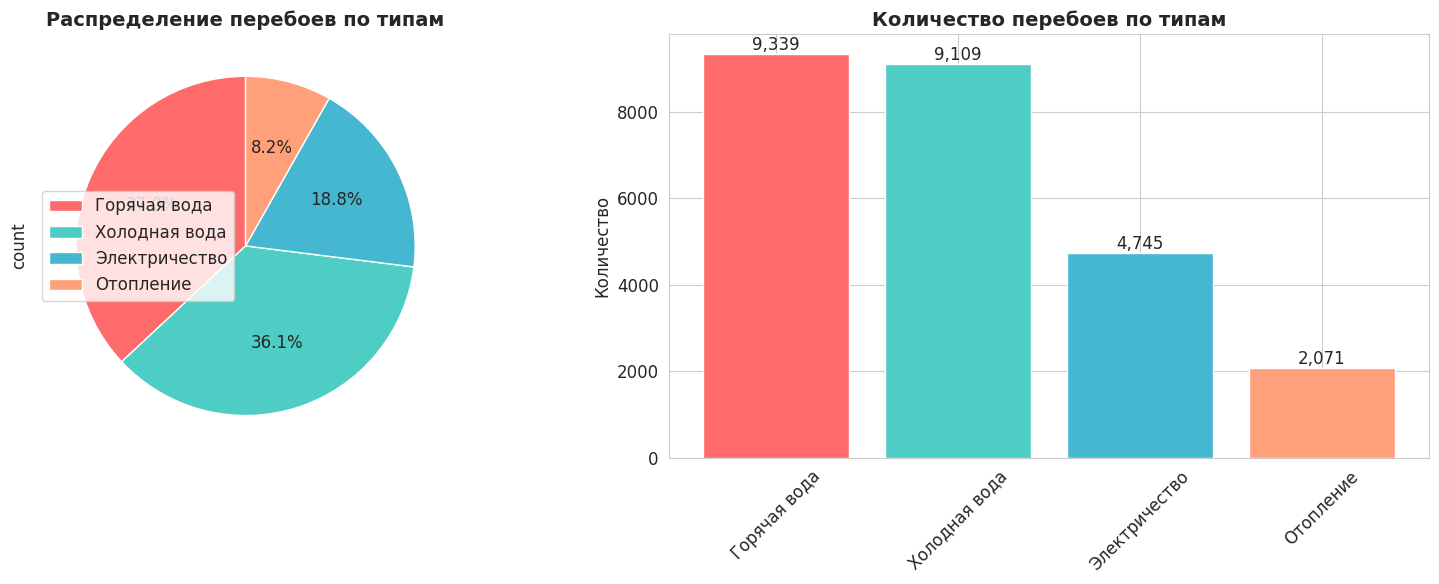

In [9]:
# Создаем визуализацию распределения по типам
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Круговая диаграмма
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
type_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                 colors=colors, startangle=90, labels=None)
axes[0].set_title('Распределение перебоев по типам', fontsize=14, fontweight='bold')
axes[0].legend([type_names.get(t, t) for t in type_counts.index], loc='best')

# График 2: Столбчатая диаграмма
bars = axes[1].bar(range(len(type_counts)), type_counts.values, color=colors)
axes[1].set_xticks(range(len(type_counts)))
axes[1].set_xticklabels([type_names.get(t, t) for t in type_counts.index], rotation=45)
axes[1].set_title('Количество перебоев по типам', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество')
for i, v in enumerate(type_counts.values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 2.3 Временная динамика перебоев


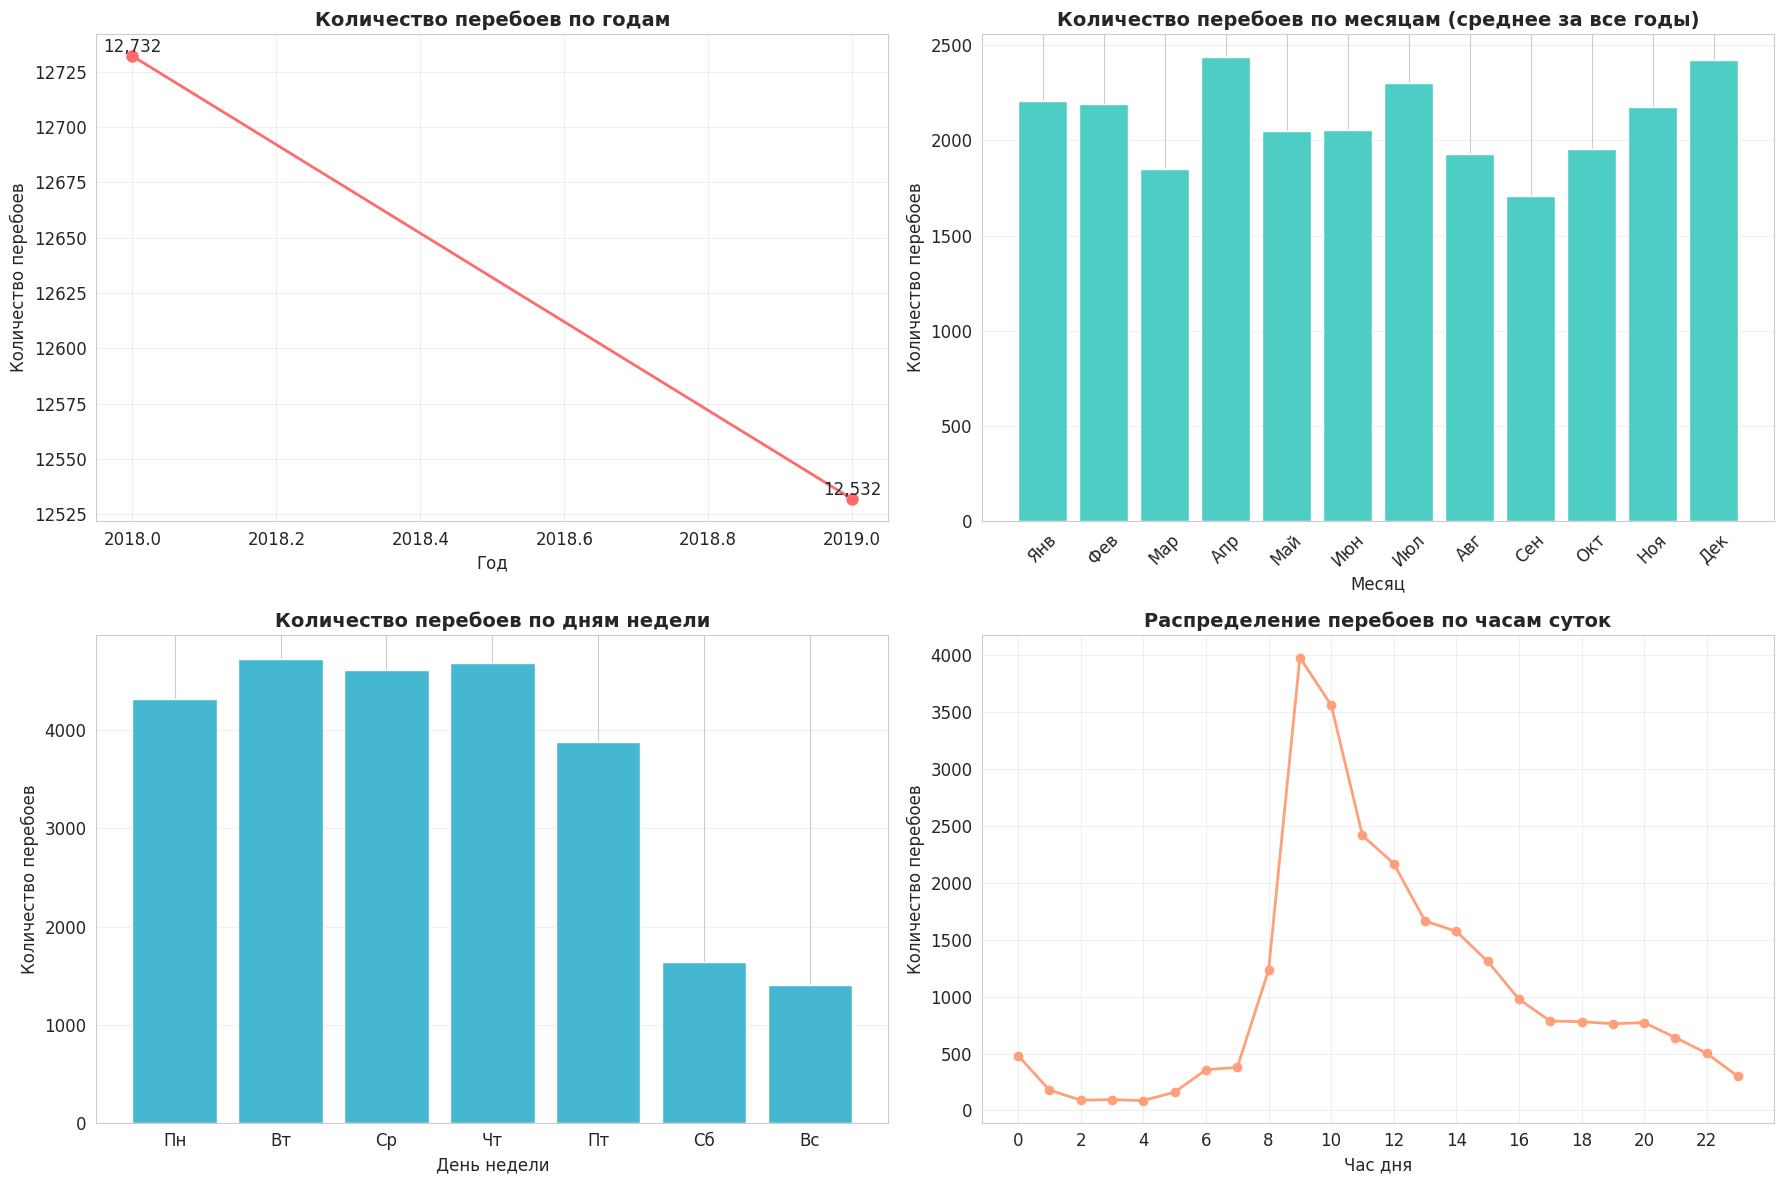

In [10]:
# Временная динамика перебоев
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# График 1: Перебои по годам
yearly_counts = blackouts_df.groupby('year').size()
axes[0, 0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[0, 0].set_title('Количество перебоев по годам', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Год')
axes[0, 0].set_ylabel('Количество перебоев')
axes[0, 0].grid(True, alpha=0.3)
for year, count in yearly_counts.items():
    axes[0, 0].text(year, count, f'{count:,}', ha='center', va='bottom')

# График 2: Перебои по месяцам
monthly_counts = blackouts_df.groupby('month').size()
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
axes[0, 1].bar(monthly_counts.index, monthly_counts.values, color='#4ECDC4')
axes[0, 1].set_title('Количество перебоев по месяцам (среднее за все годы)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('Количество перебоев')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# График 3: Перебои по дням недели
day_counts = blackouts_df.groupby('day_of_week').size()
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
axes[1, 0].bar(range(7), day_counts.values, color='#45B7D1')
axes[1, 0].set_title('Количество перебоев по дням недели', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('День недели')
axes[1, 0].set_ylabel('Количество перебоев')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(day_names)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# График 4: Перебои по часам суток
hour_counts = blackouts_df.groupby('hour').size()
axes[1, 1].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=6, color='#FFA07A')
axes[1, 1].set_title('Распределение перебоев по часам суток', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Час дня')
axes[1, 1].set_ylabel('Количество перебоев')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2.4 Анализ по районам


Топ-10 районов по количеству перебоев:
                      count  avg_duration
name_district                            
Советский район       49766     36.420200
Ленинский район       37574     65.647203
Первомайский район    32434     55.325134
Первореченский район  26952     69.193947
Фрунзенский район     16108     90.741439


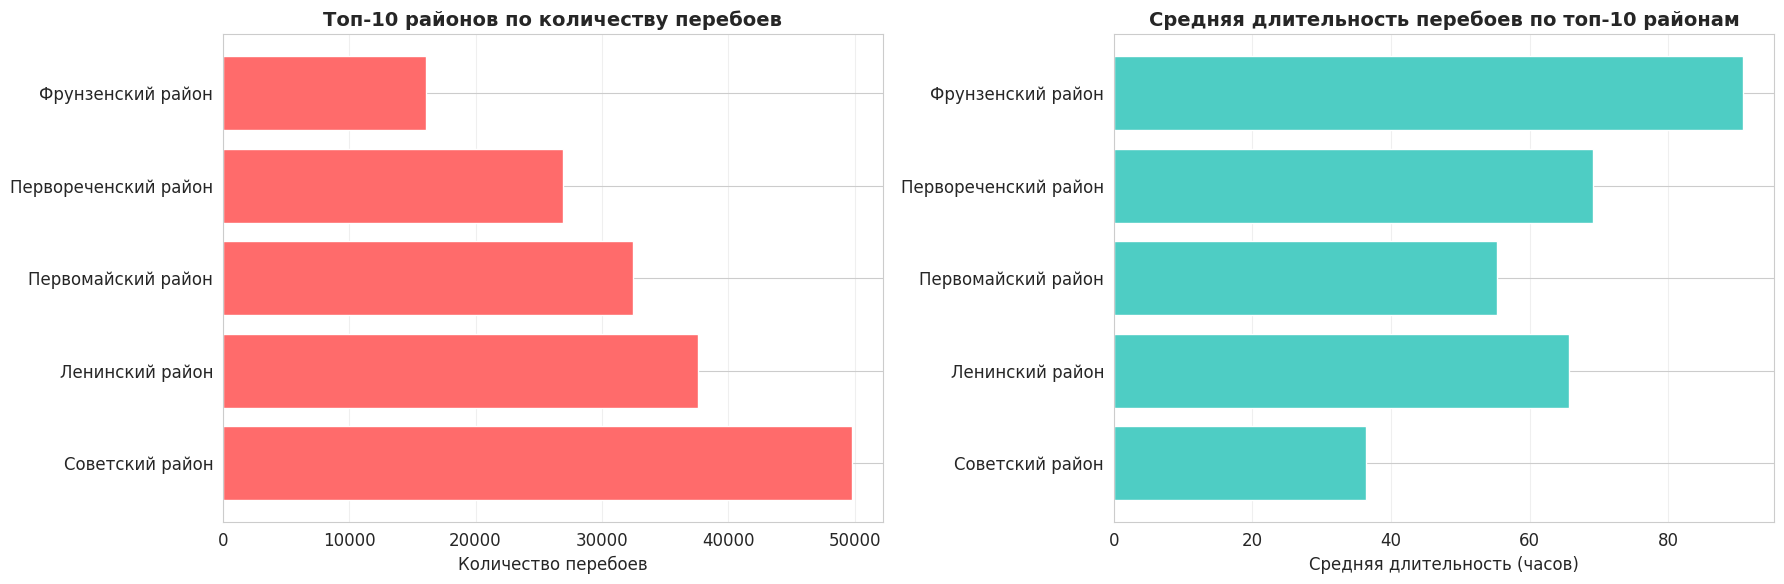

In [11]:
# Анализ перебоев по районам
if 'name_district' in full_data.columns:
    district_analysis = full_data.groupby('name_district').agg({
        'id_x': 'count',
        'duration_hours': 'mean'
    }).rename(columns={'id_x': 'count', 'duration_hours': 'avg_duration'}).sort_values('count', ascending=False)
    
    print("Топ-10 районов по количеству перебоев:")
    print(district_analysis.head(10))
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # График 1: Топ-10 районов по количеству
    top_10_districts = district_analysis.head(10)
    axes[0].barh(range(len(top_10_districts)), top_10_districts['count'], color='#FF6B6B')
    axes[0].set_yticks(range(len(top_10_districts)))
    axes[0].set_yticklabels(top_10_districts.index)
    axes[0].set_xlabel('Количество перебоев')
    axes[0].set_title('Топ-10 районов по количеству перебоев', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # График 2: Средняя длительность по топ-10 районам
    axes[1].barh(range(len(top_10_districts)), top_10_districts['avg_duration'], color='#4ECDC4')
    axes[1].set_yticks(range(len(top_10_districts)))
    axes[1].set_yticklabels(top_10_districts.index)
    axes[1].set_xlabel('Средняя длительность (часов)')
    axes[1].set_title('Средняя длительность перебоев по топ-10 районам', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("Данные о районах недоступны в объединенной таблице")


## 2.5 Длительность перебоев по типам


Статистика длительности по типам перебоев:
              mean  median     std   min      max
type                                             
cold_water   10.28    4.65   18.01  0.02   742.37
electricity   4.62    3.20    8.50  0.02   411.57
heat         11.01    5.25   18.74  0.02   263.02
hot_water    69.68    6.00  258.42  0.02  8543.22


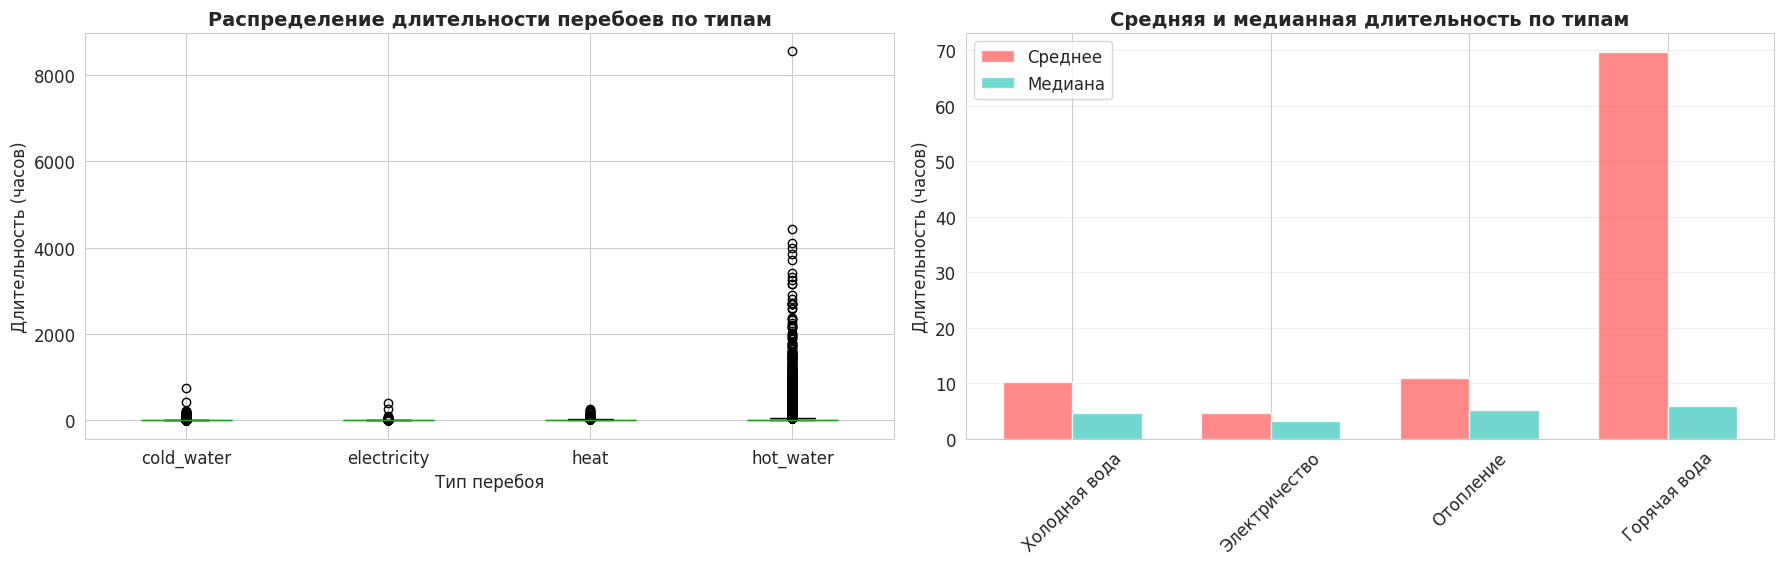

In [12]:
# Анализ длительности по типам
duration_by_type = blackouts_df.groupby('type')['duration_hours'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)

print("Статистика длительности по типам перебоев:")
print(duration_by_type)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# График 1: Boxplot длительности по типам
blackouts_df.boxplot(column='duration_hours', by='type', ax=axes[0], 
                     patch_artist=True, labels=[type_names.get(t, t) for t in sorted(blackouts_df['type'].unique())])
axes[0].set_title('Распределение длительности перебоев по типам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Тип перебоя')
axes[0].set_ylabel('Длительность (часов)')
axes[0].get_figure().suptitle('')  # Удаляем общий заголовок

# График 2: Средняя и медианная длительность
x = range(len(duration_by_type))
x_labels = [type_names.get(t, t) for t in duration_by_type.index]
width = 0.35
axes[1].bar([i - width/2 for i in x], duration_by_type['mean'], width, label='Среднее', color='#FF6B6B', alpha=0.8)
axes[1].bar([i + width/2 for i in x], duration_by_type['median'], width, label='Медиана', color='#4ECDC4', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=45)
axes[1].set_ylabel('Длительность (часов)')
axes[1].set_title('Средняя и медианная длительность по типам', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 2.6 Инициаторы и источники перебоев


ТОП-10 ИНИЦИАТОРОВ ПО КОЛИЧЕСТВУ ПЕРЕБОЕВ
initiator_name
МУПВ ВПЭС (электрические сети)                     2431
КГУП «Приморский водоканал»                        1415
ООО "Мингородок"                                    875
ООО "Невельского"                                   777
МУПВ ВПЭС (тепловые сети Первомайского района)      751
МУПВ ВПЭС (тепловые сети)                           699
ООО "УК "Комплекс коммунальных услуг"               624
ООО "Управляющая компания Первомайского района"     592
ООО "Радон"                                         575
ООО "ДВКС"                                          496
Name: count, dtype: int64


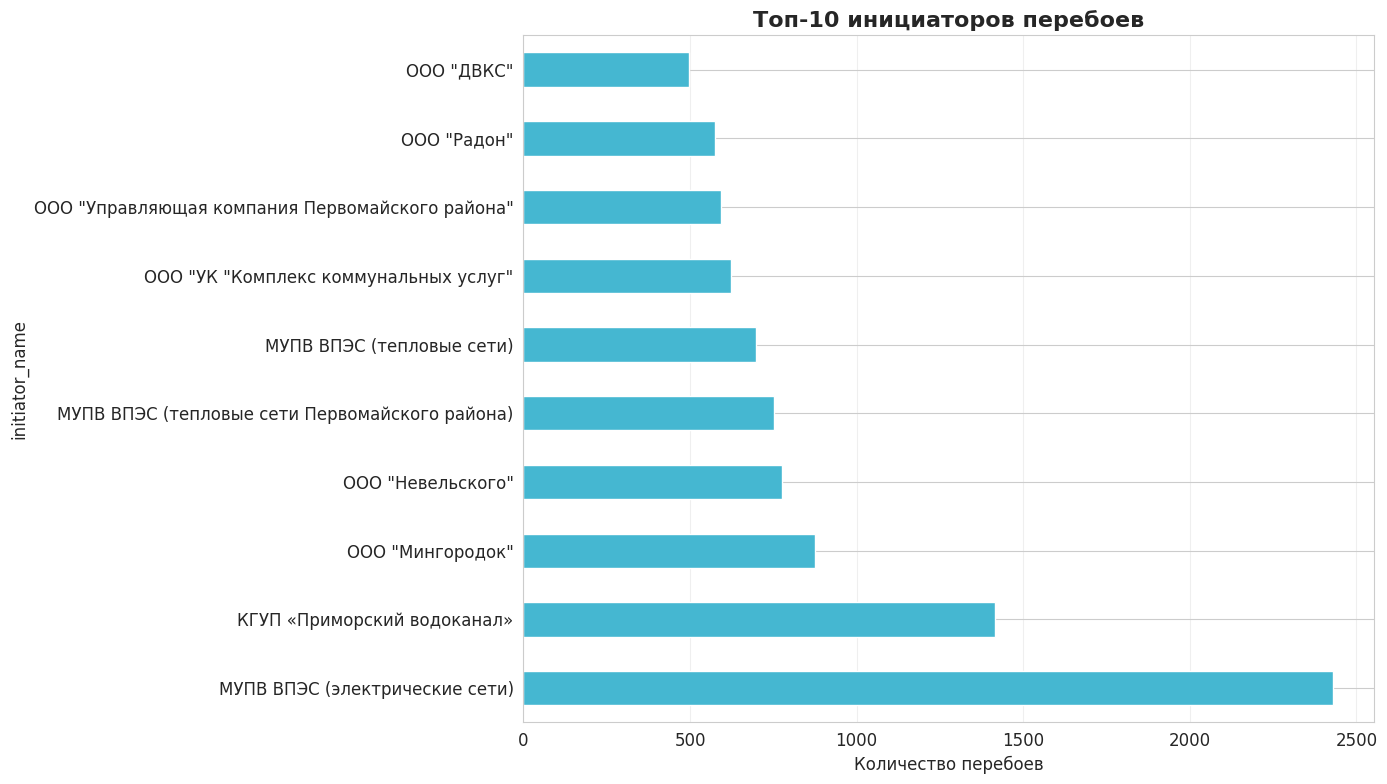

In [13]:
# Топ инициаторов
print("=" * 80)
print("ТОП-10 ИНИЦИАТОРОВ ПО КОЛИЧЕСТВУ ПЕРЕБОЕВ")
print("=" * 80)
top_initiators = blackouts_df['initiator_name'].value_counts().head(10)
print(top_initiators)

# Визуализация инициаторов
fig, ax = plt.subplots(figsize=(14, 8))
top_initiators.plot(kind='barh', color='#45B7D1', ax=ax)
ax.set_xlabel('Количество перебоев')
ax.set_title('Топ-10 инициаторов перебоев', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


# 3. СЛОЖНЫЙ УРОВЕНЬ: Инсайты и функциональные предложения

## 3.1 Анализ проблемных зон


ТОП-15 ЗДАНИЙ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ПЕРЕБОЕВ
                                  blackout_count  avg_duration  \
building_id                                                      
f6d2bac4f23afdb064b5a2cb89b95f3a             154     37.557900   
1d472afc1cf7cc3ee1770cd5a6a9106c             151     17.958057   
56a8662050820728ef9221b9c3918afc             147     37.087755   
185c43d9402daa508bbd7c4cf2e730e1             144     40.270139   
1e9f35a3fb88d1f7a2e6e60ecde65f32             142     28.143310   
d737455c15a51098144539eefc2aac00             141     22.468676   
3dd478af67bc117b12a1d6d025257ff9             140     30.028690   
d780768d15866103e97ff789d2d24ea2             126     39.784788   
27b4d2cfbbde67fb30f1f1be9de4dcac             124     31.326210   
483480811b63dbba919feb78a03e3033             122     22.073087   
ce6cfdb810f638e83883be6006ea37c2             122     38.999180   
36e9491b6ff71cfc675c9af3cb67c874             121     38.181680   
308aa10867af333244639bd4392c

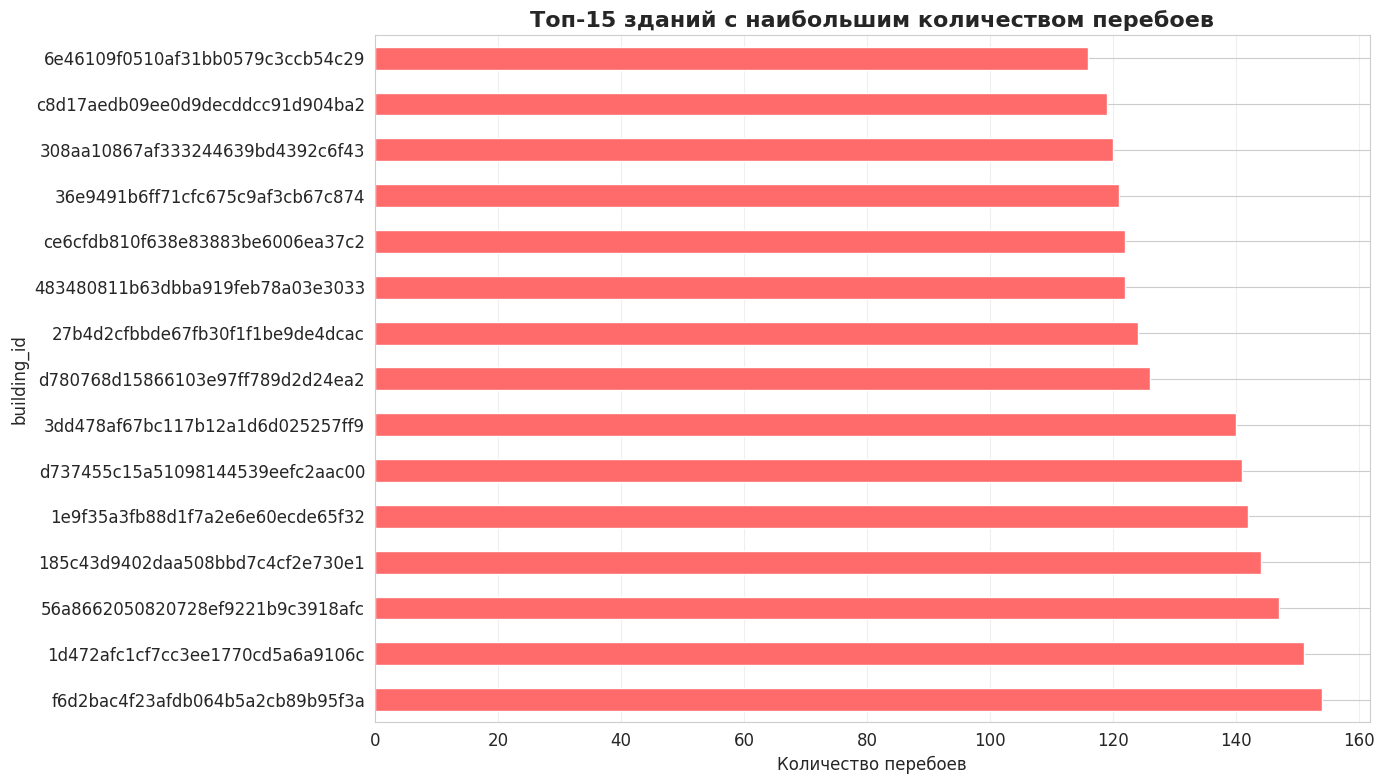

In [14]:
# Анализ проблемных зданий
if 'building_id' in full_data.columns and 'name' in full_data.columns:
    building_stats = full_data.groupby('building_id').agg({
        'id_x': 'count',
        'duration_hours': 'mean',
        'name': 'first',  # название народного района
        'number': 'first'  # номер здания
    }).rename(columns={'id_x': 'blackout_count', 'duration_hours': 'avg_duration'}).sort_values('blackout_count', ascending=False)
    
    print("=" * 80)
    print("ТОП-15 ЗДАНИЙ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ПЕРЕБОЕВ")
    print("=" * 80)
    top_15_buildings = building_stats.head(15)
    print(top_15_buildings[['blackout_count', 'avg_duration', 'name', 'number']])
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(14, 8))
    top_15_buildings['blackout_count'].plot(kind='barh', color='#FF6B6B', ax=ax)
    ax.set_xlabel('Количество перебоев')
    ax.set_title('Топ-15 зданий с наибольшим количеством перебоев', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("Данные о зданиях недоступны")


## 3.2 Ключевые инсайты из анализа


In [15]:
print("=" * 80)
print("КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ АНАЛИЗА")
print("=" * 80)

print("\n1. ОБЩАЯ КАРТИНА:")
print(f"   - За период с {blackouts_df['start_date'].min().strftime('%Y-%m-%d')} по {blackouts_df['end_date'].max().strftime('%Y-%m-%d')} зафиксировано {len(blackouts_df):,} перебоев")
print(f"   - Общая суммарная длительность: {blackouts_df['duration_hours'].sum():.0f} часов ({blackouts_df['duration_hours'].sum()/24:.0f} дней)")
print(f"   - Средняя длительность перебоя: {blackouts_df['duration_hours'].mean():.1f} часов")

print("\n2. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ:")
most_common_type = blackouts_df['type'].value_counts().index[0]
most_common_count = blackouts_df['type'].value_counts().iloc[0]
print(f"   - Самый частый тип перебоев: {type_names.get(most_common_type, most_common_type)} ({most_common_count:,} случаев, {most_common_count/len(blackouts_df)*100:.1f}%)")

print("\n3. ВРЕМЕННЫЕ ЗАКОНОМЕРНОСТИ:")
most_problematic_month = blackouts_df.groupby('month').size().idxmax()
month_name_dict = {1:'Январь', 2:'Февраль', 3:'Март', 4:'Апрель', 5:'Май', 6:'Июнь',
                   7:'Июль', 8:'Август', 9:'Сентябрь', 10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'}
print(f"   - Самый проблемный месяц: {month_name_dict.get(most_problematic_month, most_problematic_month)}")
most_problematic_weekday = blackouts_df.groupby('day_of_week').size().idxmax()
weekday_name_dict = {0:'Понедельник', 1:'Вторник', 2:'Среда', 3:'Четверг', 
                     4:'Пятница', 5:'Суббота', 6:'Воскресенье'}
print(f"   - Самый проблемный день недели: {weekday_name_dict.get(most_problematic_weekday, most_problematic_weekday)}")

avg_weekday = blackouts_df[blackouts_df['is_weekend']==0]['duration_hours'].mean()
avg_weekend = blackouts_df[blackouts_df['is_weekend']==1]['duration_hours'].mean()
print(f"   - Средняя длительность перебоя в будни: {avg_weekday:.1f} часов")
print(f"   - Средняя длительность перебоя в выходные: {avg_weekend:.1f} часов")

print("\n4. ПРОБЛЕМНЫЕ ЗОНЫ:")
if 'name_district' in full_data.columns:
    problem_district = full_data.groupby('name_district').size().idxmax()
    problem_district_count = full_data.groupby('name_district').size().max()
    print(f"   - Район с наибольшим количеством перебоев: {problem_district} ({problem_district_count:,} случаев)")

print("\n5. КАЧЕСТВО СЕРВИСА:")
weekend_share = blackouts_df['is_weekend'].sum() / len(blackouts_df) * 100
print(f"   - Доля перебоев в выходные дни: {weekend_share:.1f}%")
access_issue_share = blackouts_df['has_access_issue'].sum() / len(blackouts_df) * 100
print(f"   - Доля перебоев с проблемами доступа к ремонтным работам: {access_issue_share:.1f}%")
accident_share = blackouts_df['has_accident'].sum() / len(blackouts_df) * 100
print(f"   - Доля перебоев по причине аварий: {accident_share:.1f}%")


КЛЮЧЕВЫЕ ИНСАЙТЫ ИЗ АНАЛИЗА

1. ОБЩАЯ КАРТИНА:
   - За период с 2018-01-01 по 2020-01-09 зафиксировано 25,264 перебоев
   - Общая суммарная длительность: 789092 часов (32879 дней)
   - Средняя длительность перебоя: 31.2 часов

2. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ:
   - Самый частый тип перебоев: Горячая вода (9,339 случаев, 37.0%)

3. ВРЕМЕННЫЕ ЗАКОНОМЕРНОСТИ:
   - Самый проблемный месяц: Апрель
   - Самый проблемный день недели: Вторник
   - Средняя длительность перебоя в будни: 30.9 часов
   - Средняя длительность перебоя в выходные: 33.8 часов

4. ПРОБЛЕМНЫЕ ЗОНЫ:
   - Район с наибольшим количеством перебоев: Советский район (53,921 случаев)

5. КАЧЕСТВО СЕРВИСА:
   - Доля перебоев в выходные дни: 12.0%
   - Доля перебоев с проблемами доступа к ремонтным работам: 5.4%
   - Доля перебоев по причине аварий: 33.4%


## 3.3 Предложение функционала: Система раннего оповещения и прогнозирования

### Концепция

**Проблема:** Жители Владивостока не получают своевременных уведомлений о планируемых перебоях и не могут спланировать свою деятельность.

**Решение:** Разработка системы раннего оповещения с элементами прогнозирования на основе исторических данных.

### Преимущества:
1. **Проактивность**: Предупреждение за 2-6 часов до начала перебоя
2. **Персонализация**: Уведомления только о перебоях в районе пользователя
3. **Прогнозирование**: Оценка вероятности перебоя на основе паттернов

### Технический подход:
- Анализ исторических паттернов по районам и типам
- Модель, учитывающая время года, день недели, погоду
- Push-уведомления через мобильное приложение
- СМС-рассылка для критичных перебоев


In [16]:
# Прототип: Функция оценки вероятности перебоя для конкретного здания
def estimate_blackout_probability(building_id, target_date, blackouts_df, full_data, buildings_df):
    """
    Оценивает вероятность перебоя для конкретного здания в заданную дату
    на основе исторических данных.
    
    Параметры:
    - building_id: ID здания
    - target_date: Дата для прогноза (datetime)
    - blackouts_df: DataFrame с перебоями
    - full_data: Объединенные данные
    - buildings_df: DataFrame с зданиями
    
    Возвращает:
    - Словарь с вероятностями по типам перебоев
    """
    
    # Получаем информацию о здании
    building_info = buildings_df[buildings_df['id'] == building_id]
    if building_info.empty:
        return {"error": "Здание не найдено"}
    
    # Получаем исторические данные по этому зданию
    building_blackouts = full_data[full_data['building_id'] == building_id].copy()
    
    if building_blackouts.empty:
        return {"error": "Нет исторических данных"}
    
    # Извлекаем признаки из целевой даты
    target_month = target_date.month
    target_weekday = target_date.weekday()
    target_hour = target_date.hour
    target_is_weekend = 1 if target_weekday >= 5 else 0
    
    # Считаем вероятности по типам
    probabilities = {}
    
    for outage_type in ['electricity', 'cold_water', 'hot_water', 'heat']:
        # Находим исторические перебои этого типа для здания
        type_blackouts = building_blackouts[building_blackouts['type'] == outage_type]
        
        if type_blackouts.empty:
            probabilities[outage_type] = 0.0
            continue
        
        # Считаем базовую вероятность (сколько раз случалось в день в среднем)
        avg_per_day = len(type_blackouts) / ((building_blackouts['start_date'].max() - 
                                              building_blackouts['start_date'].min()).days + 1)
        
        # Применяем временные модификаторы
        month_factor = 1.0
        if target_month in type_blackouts.groupby('month').size().index:
            month_occurrences = type_blackouts.groupby('month').size()[target_month]
            month_avg = type_blackouts.groupby('month').size().mean()
            month_factor = month_occurrences / month_avg if month_avg > 0 else 1.0
        
        # Учитываем день недели
        weekday_factor = 1.0
        if target_weekday in type_blackouts.groupby('day_of_week').size().index:
            weekday_occurrences = type_blackouts.groupby('day_of_week').size()[target_weekday]
            weekday_avg = type_blackouts.groupby('day_of_week').size().mean()
            weekday_factor = weekday_occurrences / weekday_avg if weekday_avg > 0 else 1.0
        
        # Итоговая вероятность
        probability = avg_per_day * month_factor * weekday_factor
        probabilities[outage_type] = min(probability, 1.0)  # Ограничиваем 1.0
    
    return probabilities

# Демонстрация работы функции
print("=" * 80)
print("ДЕМОНСТРАЦИЯ ПРОТОТИПА СИСТЕМЫ ПРОГНОЗИРОВАНИЯ")
print("=" * 80)

# Берем первое здание с историей перебоев
sample_buildings = full_data['building_id'].value_counts().head(5)
for building_id in sample_buildings.index[:3]:
    print(f"\nЗдание ID: {building_id}")
    
    # Проверяем вероятность на завтра
    tomorrow = pd.Timestamp.now() + pd.Timedelta(days=1)
    probabilities = estimate_blackout_probability(building_id, tomorrow, blackouts_df, full_data, buildings_df)
    
    if 'error' not in probabilities:
        for outage_type, prob in probabilities.items():
            print(f"  {type_names.get(outage_type, outage_type)}: {prob*100:.2f}%")
    else:
        print(f"  {probabilities['error']}")

print("\n" + "=" * 80)


ДЕМОНСТРАЦИЯ ПРОТОТИПА СИСТЕМЫ ПРОГНОЗИРОВАНИЯ

Здание ID: f6d2bac4f23afdb064b5a2cb89b95f3a


KeyError: 'type'

# Заключение

Данный анализ продемонстрировал:

1. **Подготовка данных** (Базовый уровень): Успешно загружены, очищены и обогащены данные из 6 источников
2. **Анализ и визуализация** (Средний уровень): Выявлены ключевые закономерности и созданы информативные визуализации
3. **Инсайты и предложения** (Сложный уровень): Разработана система раннего оповещения с демонстрационным прототипом

**Следующие шаги**: Внедрение в продукт VL-OFF и итеративная разработка с учетом пользовательской обратной связи.


In [ ]:
# Сохранение результатов анализа
print("=" * 80)
print("СОХРАНЕНИЕ ОСНОВНЫХ МЕТРИК")
print("=" * 80)

results_summary = {
    'Период анализа': f"{blackouts_df['start_date'].min()} - {blackouts_df['end_date'].max()}",
    'Всего перебоев': len(blackouts_df),
    'Средняя длительность (часов)': round(blackouts_df['duration_hours'].mean(), 2),
    'Общая длительность (дней)': round(blackouts_df['duration_hours'].sum() / 24, 2),
    'Уникальных зданий': blackouts_df['start_date'].max() - blackouts_df['start_date'].min()
}

print("\nИтоговая статистика:")
for key, value in results_summary.items():
    print(f"  {key}: {value}")

print("\n" + "=" * 80)
print("АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")
print("=" * 80)
print("\nДля подробной информации см. report.md")
